In [16]:
import numpy as np
from keras.datasets import mnist
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Flatten
from sklearn.linear_model import LogisticRegression

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

# Convolutional Neural Networks

A convolutional neural network takes the idea of a basic NN further, constraining each $W$ to be convolutions. Convolutions are linear functions, so they can be represented in this form, but they require fewer parameters than other methods, as weights can be shared across the whole image, with each filter serving as a global detector of a pattern. The model I chose can be viewed below, but essentially there are several sets of convolutions, and to decrease the dimensionality of the outputs, I use strided convolutions. This model (with no 1x1 convolutions) has about 1.25 million learnable parameters, which is much more than logistic regression's $785\cdot 10 = 7850$ parameters, and also is an indicator that the model probably has the capacity to overfit significantly. Most of these parameters come from the first fully connected layer, which has 768 outputs and 500-1500 inputs, which instantly adds many learnable parameters. We can see removing this layer and including 1x1 convolutions before each conv layer, which results in about 25000 learnable parameters, and much lower model capacity. Interestingly, even with these few parameters, the model still overfits.

After a few epochs of training, this reaches about 98-99 percent test accuracy, which is significantly better than logistic regression. State of the art classifiers on MNIST typically achieve about 99.5% accuracy, which is near the bayes error rate on this dataset.

In [10]:
(x_train, y_train_orig), (x_test, y_test_orig) = mnist.load_data()
x_train = x_train[..., None] / 255.0
x_test = x_test[..., None] / 255.0
y_train = keras.utils.to_categorical(y_train_orig)
y_test = keras.utils.to_categorical(y_test_orig)

In [62]:
np.random.seed(1151998)
model = keras.models.Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(28, 28, 1), activation='relu'))
model.add(Conv2D(16, (1,1), activation='relu'))
model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Conv2D(16, (1,1), activation='relu'))
model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Conv2D(16, (1,1), activation='relu'))
model.add(Flatten())
# model.add(Dense(768, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(keras.optimizers.Adam(), keras.losses.categorical_crossentropy,
             metrics=['accuracy'])

In [39]:
print('%d learnable parameters'%model.count_params())

24186 learnable parameters


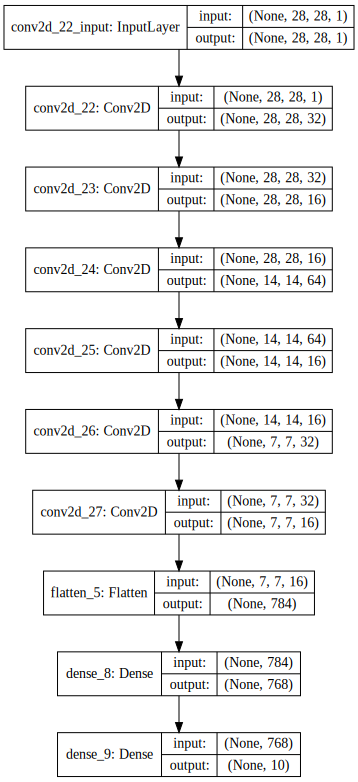

In [33]:
SVG(model_to_dot(model, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
np.random.seed(1151998)
model.fit(x_train, y_train, epochs=3)

In [63]:
model.load_weights('./simple_cnn.h5')

In [59]:
print('Test loss: %.4f, Test accuracy: %.4f'%tuple(model.evaluate(x_test, y_test, verbose=0)))

Test loss: 0.0482, Test accuracy: 0.9845


In [53]:
pred_y = model.predict(x_test)

Text(0.5,1,'Confusion Matrix')

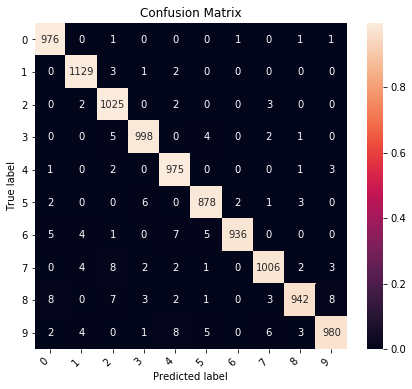

In [54]:
conf_mat = metrics.confusion_matrix(y_test_orig, pred_y.argmax(1))
class_names = list(range(10))
cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(
    cm, index=class_names, columns=class_names, 
)
fig = plt.figure(figsize=(7, 6))
heatmap = sns.heatmap(df_cm, annot=conf_mat, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')